In [1]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qick import *

# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSpan, QickSweep1D

# crank up the logging (optional)
import logging
# logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.INFO, force=True, format='%(levelname)-8s [%(filename)s:%(lineno)d] %(message)s')

Connect to zcu216 using PYRO4

In [2]:
import Pyro4
from qick import QickConfig
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

ns_host = "192.168.1.135"
ns_port = 8000
proxy_name = "rfsoc"

ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
print(soccfg)

QICK running on ZCU216, software version 0.2.280

Firmware configuration (built Thu May 30 14:53:02 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	12 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 32768 samples (13.333 us)
		fs=2457.600 MHz, fabric=153.600 

Define Channels and Constant Variables

In [6]:
# DAC Signal Generating Channels
GEN_CH0 = 0
GEN_CH1 = 1
GEN_CH2 = 2
GEN_CH3 = 3
GEN_CH4 = 4
GEN_CH5 = 5
GEN_CH6 = 6
GEN_CH7 = 7
GEN_CH8 = 8
GEN_CH9 = 9
GEN_CH10 = 10
GEN_CH11 = 11

# ADC Readout Channels
RO_CH0 = 0
RO_CH1 = 1
RO_CH2 = 2
RO_CH3 = 3
RO_CH4 = 4
RO_CH5 = 5

# Time and Frequency
TRIG_TIME = 0.40 # [us]
FREQ = 500 # [MHz]

Create and Run the Program

  0%|          | 0/10 [00:00<?, ?it/s]

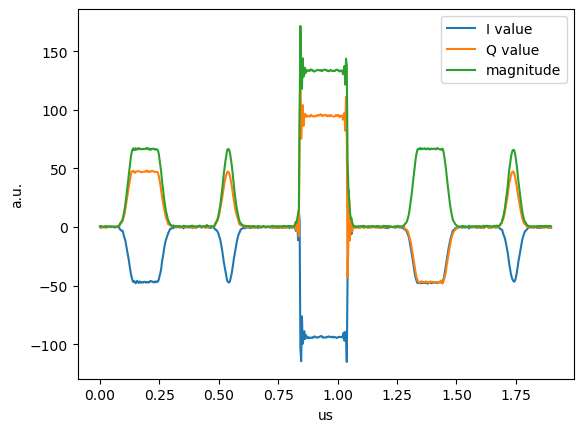

In [7]:
class MultiPulseProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)

        ramp_len = 0.2
        self.add_gauss(ch=gen_ch, name="ramp", sigma=ramp_len/10, length=ramp_len, even_length=True)
        
        self.add_pulse(ch=gen_ch, name="myflattop", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=0.1,
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="mygaus", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="myconst", ro_ch=ro_ch, 
                       style="const", 
                       length=0.2, 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0,
                      )

        self.add_pulse(ch=gen_ch, name="myflattop2", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=0.1,
                       phase=90,
                       gain=1.0, 
                      )
        
    def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)

        self.pulse(ch=cfg['gen_ch'], name="myflattop", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mygaus", t=0.4)
        self.pulse(ch=cfg['gen_ch'], name="myconst", t=0.8)
        self.pulse(ch=cfg['gen_ch'], name="myflattop2", t=1.2)
        self.pulse(ch=cfg['gen_ch'], name="mygaus", t=1.6)
        
config = {'gen_ch': GEN_CH0,
          'ro_ch': RO_CH0,
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          'ro_len': 1.9,
         }

prog = MultiPulseProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=10)
t = prog.get_time_axis(ro_index=0)

plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");

MUX testing program

In [ ]:
class MUXPulseProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1, ro_ch=cfg['ro_ch'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)

        ramp_len = 0.2
        self.add_gauss(ch=gen_ch, name="ramp", sigma=ramp_len/10, length=ramp_len, even_length=True)
        
        self.add_pulse(ch=gen_ch, name="myflattop", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=0.1,
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="mygaus", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="myconst", ro_ch=ro_ch, 
                       style="const", 
                       length=0.2, 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0,
                      )

        self.add_pulse(ch=gen_ch, name="myflattop2", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=0.1,
                       phase=90,
                       gain=1.0, 
                      )
        
    def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)

        self.pulse(ch=cfg['gen_ch'], name="myflattop", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mygaus", t=0.4)
        self.pulse(ch=cfg['gen_ch'], name="myconst", t=0.8)
        self.pulse(ch=cfg['gen_ch'], name="myflattop2", t=1.2)
        self.pulse(ch=cfg['gen_ch'], name="mygaus", t=1.6)
        
config = {'gen_ch': GEN_CH10,
          'ro_ch': [RO_CH2, RO_CH3, RO_CH4, RO_CH5],
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          'ro_len': 1.9,
         }

prog = MUXPulseProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=10)
t = prog.get_time_axis(ro_index=0)

plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");